In [1]:
!pip install optuna


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False,gamma=1):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = gamma # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [3]:
import numpy as np
from scipy.special import softmax

def sarsa(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using SARSA.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run SARSA for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    # initialize the state-action value function and the state counts
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))
    
    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):

        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        # for each new episode, start at the given start state
        state = int(model.start_state_seq)
        # sample first action
        action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            # initialize p and r
            p, r = 0, np.random.random()
            # sample the next state according to the action and the
            # probability of the transition
            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break
            # sample the next action
            next_action = sample_action(Q, next_state, model.num_actions, epsilon, temperature, action_strategy)
            # Calculate the temporal difference and update Q function
            Q[state, action] += alpha * (model.R[state] + model.gamma * Q[next_state, next_action] - Q[state, action])
            # End episode is state is a terminal state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

            # count the state visits
            state_counts[state] += 1

            # store the previous state and action
            state = next_state
            action = next_action

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    # determine the q function and policy
    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

def sample_action(Q, state, num_actions, epsilon, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Action selection based on the specified strategy.

    Parameters
    ----------
    Q : numpy array of shape (N, num_actions)
        Q function for the environment where N is the total number of states.

    state : int
        The current state.

    num_actions : int
        The number of actions.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    action : int
        Number representing the selected action between 0 and num_actions.
    """
    if action_strategy == 'epsilon-greedy':
        if np.random.random() < epsilon:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(Q[state, :])
    elif action_strategy == 'softmax':
        action_values = Q[state, :]
        probabilities = softmax(action_values / temperature)
        action = np.random.choice(np.arange(num_actions), p=probabilities)
    else:
        raise ValueError("Invalid action_strategy. Use 'epsilon-greedy' or 'softmax'.")

    return action


def qlearning(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using Q-learning.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run Q-learning for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))

    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):
        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        state = int(model.start_state_seq)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)

            p, r = 0, np.random.random()

            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break

            Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])

            state_counts[state] += 1

            state = next_state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from plots import plot_gridworld

In [5]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)

env_0 = gw.create_gridworld()


In [6]:
import optuna

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = qlearning(env_0, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 17:28:58,481] A new study created in memory with name: no-name-b8da0b2b-e2ab-49da-bbe1-353afd408f32
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:243: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:255: DeprecationWarning: Conversion of an array with ndi

Trial 0: Alpha = 0.324772622452745, Epsilon = 0.12880385659383073,Gamma=0.9996011106319715
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:29:57,939] Trial 0 finished with value: 196843.5 and parameters: {'alpha': 0.324772622452745, 'epsilon': 0.12880385659383073, 'gamma': 0.9996011106319715}. Best is trial 0 with value: 196843.5.


Trial 1: Alpha = 0.13773431108308823, Epsilon = 0.10997102097523714,Gamma=0.8843389624417933
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:31:13,204] Trial 1 finished with value: 246149.5 and parameters: {'alpha': 0.13773431108308823, 'epsilon': 0.10997102097523714, 'gamma': 0.8843389624417933}. Best is trial 0 with value: 196843.5.


Trial 2: Alpha = 0.12061395748440663, Epsilon = 0.2227520130498538,Gamma=0.854655490292727
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:32:28,666] Trial 2 finished with value: 361821.0 and parameters: {'alpha': 0.12061395748440663, 'epsilon': 0.2227520130498538, 'gamma': 0.854655490292727}. Best is trial 0 with value: 196843.5.


Trial 3: Alpha = 0.21880678116615107, Epsilon = 0.2664894406289399,Gamma=0.804913910323845
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:34:01,673] Trial 3 finished with value: 427077.0 and parameters: {'alpha': 0.21880678116615107, 'epsilon': 0.2664894406289399, 'gamma': 0.804913910323845}. Best is trial 0 with value: 196843.5.


Trial 4: Alpha = 0.18661220557172334, Epsilon = 0.15558498686562053,Gamma=0.9836819953843892
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:34:59,788] Trial 4 finished with value: 209911.0 and parameters: {'alpha': 0.18661220557172334, 'epsilon': 0.15558498686562053, 'gamma': 0.9836819953843892}. Best is trial 0 with value: 196843.5.


Trial 5: Alpha = 0.22298566862950772, Epsilon = 0.3709185156979072,Gamma=0.9417976794329627
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:36:28,857] Trial 5 finished with value: 422825.5 and parameters: {'alpha': 0.22298566862950772, 'epsilon': 0.3709185156979072, 'gamma': 0.9417976794329627}. Best is trial 0 with value: 196843.5.


Trial 6: Alpha = 0.36192110344412265, Epsilon = 0.26243916503141734,Gamma=0.9904156657883231
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:37:36,364] Trial 6 finished with value: 286264.5 and parameters: {'alpha': 0.36192110344412265, 'epsilon': 0.26243916503141734, 'gamma': 0.9904156657883231}. Best is trial 0 with value: 196843.5.


Trial 7: Alpha = 0.42195539828368656, Epsilon = 0.24075319317678587,Gamma=0.9861077079139193
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:38:40,971] Trial 7 finished with value: 282568.2 and parameters: {'alpha': 0.42195539828368656, 'epsilon': 0.24075319317678587, 'gamma': 0.9861077079139193}. Best is trial 0 with value: 196843.5.


Trial 8: Alpha = 0.21193856545633225, Epsilon = 0.1417755772175258,Gamma=0.8162642120413802
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:39:56,621] Trial 8 finished with value: 289418.2 and parameters: {'alpha': 0.21193856545633225, 'epsilon': 0.1417755772175258, 'gamma': 0.8162642120413802}. Best is trial 0 with value: 196843.5.


Trial 9: Alpha = 0.29992557819783333, Epsilon = 0.10116173237320215,Gamma=0.9041307417857396
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:40:59,322] Trial 9 finished with value: 235840.0 and parameters: {'alpha': 0.29992557819783333, 'epsilon': 0.10116173237320215, 'gamma': 0.9041307417857396}. Best is trial 0 with value: 196843.5.


Trial 10: Alpha = 0.30123706057326805, Epsilon = 0.15799983942067633,Gamma=0.937623859376403
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:41:56,425] Trial 10 finished with value: 255080.4 and parameters: {'alpha': 0.30123706057326805, 'epsilon': 0.15799983942067633, 'gamma': 0.937623859376403}. Best is trial 0 with value: 196843.5.


Trial 11: Alpha = 0.16063061459908562, Epsilon = 0.15621608423208538,Gamma=0.9979483591311112
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:42:44,772] Trial 11 finished with value: 208654.0 and parameters: {'alpha': 0.16063061459908562, 'epsilon': 0.15621608423208538, 'gamma': 0.9979483591311112}. Best is trial 0 with value: 196843.5.


Trial 12: Alpha = 0.15975904166824603, Epsilon = 0.1814154901525929,Gamma=0.9513118286783839
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:43:38,737] Trial 12 finished with value: 250497.5 and parameters: {'alpha': 0.15975904166824603, 'epsilon': 0.1814154901525929, 'gamma': 0.9513118286783839}. Best is trial 0 with value: 196843.5.


Trial 13: Alpha = 0.2958832553152536, Epsilon = 0.12709190538523968,Gamma=0.961818373229433
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:44:30,403] Trial 13 finished with value: 213615.7 and parameters: {'alpha': 0.2958832553152536, 'epsilon': 0.12709190538523968, 'gamma': 0.961818373229433}. Best is trial 0 with value: 196843.5.


Trial 14: Alpha = 0.499229865733461, Epsilon = 0.19332543084179935,Gamma=0.9111485414674425
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:45:48,254] Trial 14 finished with value: 346511.5 and parameters: {'alpha': 0.499229865733461, 'epsilon': 0.19332543084179935, 'gamma': 0.9111485414674425}. Best is trial 0 with value: 196843.5.


Trial 15: Alpha = 0.10286583754591042, Epsilon = 0.12563595299848976,Gamma=0.9986140735217272
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:46:41,813] Trial 15 finished with value: 200081.3 and parameters: {'alpha': 0.10286583754591042, 'epsilon': 0.12563595299848976, 'gamma': 0.9986140735217272}. Best is trial 0 with value: 196843.5.


Trial 16: Alpha = 0.1080102168343793, Epsilon = 0.12025573350774815,Gamma=0.8502991359413532
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:47:53,360] Trial 16 finished with value: 268062.30000000005 and parameters: {'alpha': 0.1080102168343793, 'epsilon': 0.12025573350774815, 'gamma': 0.8502991359413532}. Best is trial 0 with value: 196843.5.


Trial 17: Alpha = 0.3575228808094847, Epsilon = 0.494459621485508,Gamma=0.968219958641188
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:49:20,115] Trial 17 finished with value: 533560.1000000001 and parameters: {'alpha': 0.3575228808094847, 'epsilon': 0.494459621485508, 'gamma': 0.968219958641188}. Best is trial 0 with value: 196843.5.


Trial 18: Alpha = 0.24704792149033933, Epsilon = 0.12942750147448176,Gamma=0.9269858606491809
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:50:23,395] Trial 18 finished with value: 234377.90000000002 and parameters: {'alpha': 0.24704792149033933, 'epsilon': 0.12942750147448176, 'gamma': 0.9269858606491809}. Best is trial 0 with value: 196843.5.


Trial 19: Alpha = 0.26133473427489395, Epsilon = 0.30867211528985555,Gamma=0.8704997406764529
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:51:48,872] Trial 19 finished with value: 456761.9 and parameters: {'alpha': 0.26133473427489395, 'epsilon': 0.30867211528985555, 'gamma': 0.8704997406764529}. Best is trial 0 with value: 196843.5.


In [8]:

best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.324772622452745
Best Epsilon: 0.12880385659383073
Best gamma: 0.9996011106319715


In [9]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_0, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:243: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:255: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array bef

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [10]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


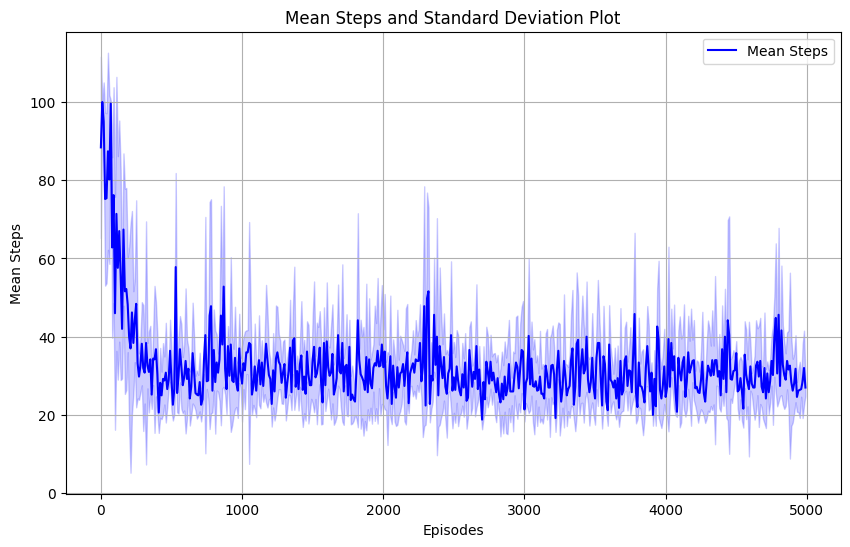

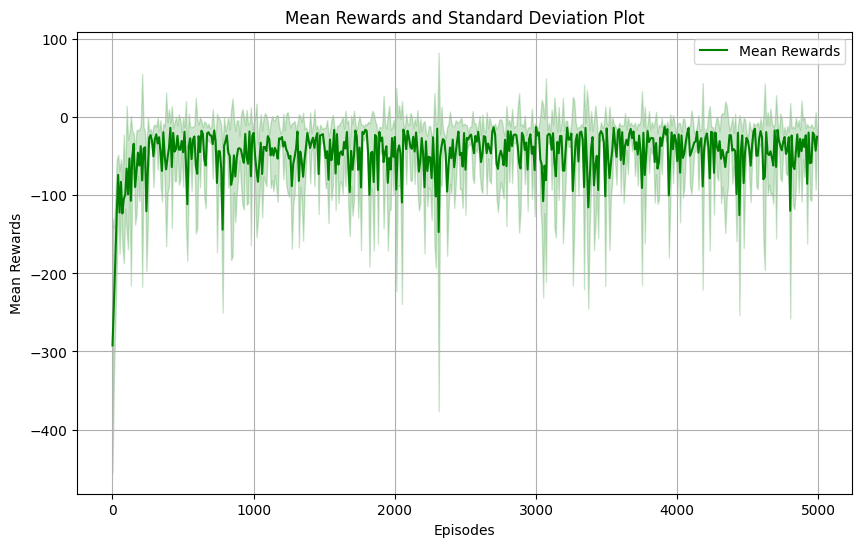

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


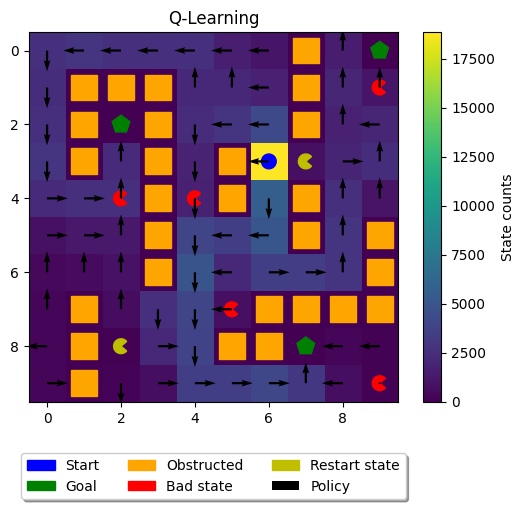

In [12]:
plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="Q-Learning")

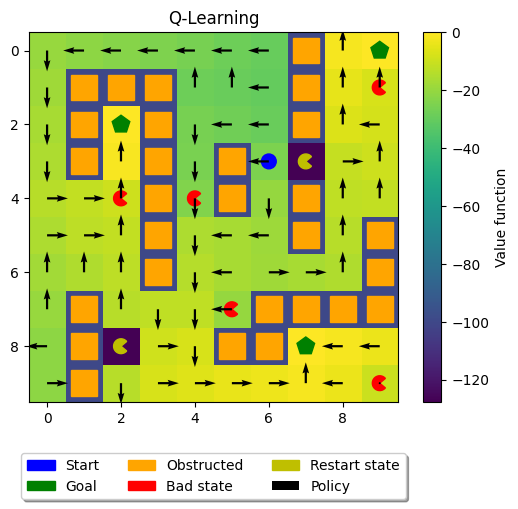

In [13]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="Q-Learning")

In [14]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = qlearning(env_0, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 17:52:41,414] A new study created in memory with name: no-name-ef724433-ff30-415f-b185-be618e2acd69
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:243: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:255: DeprecationWarning: Conversion of an array with ndi

Trial 0: Alpha = 0.4034538768729935, Temperature = 0.7685095028538007,Gamma=0.8940595258454769
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:56:23,843] Trial 0 finished with value: 411776.1 and parameters: {'alpha': 0.4034538768729935, 'temperature': 0.7685095028538007, 'gamma': 0.8940595258454769}. Best is trial 0 with value: 411776.1.


Trial 1: Alpha = 0.14379532481557633, Temperature = 0.31247209545041,Gamma=0.9802350170179662
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 17:57:59,503] Trial 1 finished with value: 148358.2 and parameters: {'alpha': 0.14379532481557633, 'temperature': 0.31247209545041, 'gamma': 0.9802350170179662}. Best is trial 1 with value: 148358.2.


Trial 2: Alpha = 0.1085675354041392, Temperature = 0.5510575024991223,Gamma=0.9097473099451342
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:01:12,403] Trial 2 finished with value: 349065.8 and parameters: {'alpha': 0.1085675354041392, 'temperature': 0.5510575024991223, 'gamma': 0.9097473099451342}. Best is trial 1 with value: 148358.2.


Trial 3: Alpha = 0.17054683091383746, Temperature = 0.8747951593716325,Gamma=0.8679306732826313
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:05:11,642] Trial 3 finished with value: 438505.30000000005 and parameters: {'alpha': 0.17054683091383746, 'temperature': 0.8747951593716325, 'gamma': 0.8679306732826313}. Best is trial 1 with value: 148358.2.


Trial 4: Alpha = 0.21436918296621613, Temperature = 0.46926330222212714,Gamma=0.8874133779797735
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:08:44,964] Trial 4 finished with value: 378580.0 and parameters: {'alpha': 0.21436918296621613, 'temperature': 0.46926330222212714, 'gamma': 0.8874133779797735}. Best is trial 1 with value: 148358.2.


Trial 5: Alpha = 0.2779577163837594, Temperature = 0.3569490071614905,Gamma=0.9456123992275302
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:10:47,345] Trial 5 finished with value: 192760.8 and parameters: {'alpha': 0.2779577163837594, 'temperature': 0.3569490071614905, 'gamma': 0.9456123992275302}. Best is trial 1 with value: 148358.2.


Trial 6: Alpha = 0.36382182253984513, Temperature = 0.1189912287840104,Gamma=0.8301635133318829
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:14:11,350] Trial 6 finished with value: 369020.2 and parameters: {'alpha': 0.36382182253984513, 'temperature': 0.1189912287840104, 'gamma': 0.8301635133318829}. Best is trial 1 with value: 148358.2.


Trial 7: Alpha = 0.1780029810843052, Temperature = 0.2754140602904084,Gamma=0.8386121125512663
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:17:54,052] Trial 7 finished with value: 403845.8 and parameters: {'alpha': 0.1780029810843052, 'temperature': 0.2754140602904084, 'gamma': 0.8386121125512663}. Best is trial 1 with value: 148358.2.


Trial 8: Alpha = 0.42859566833474855, Temperature = 0.43246904156980465,Gamma=0.9932213756354435
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:19:14,918] Trial 8 finished with value: 127083.9 and parameters: {'alpha': 0.42859566833474855, 'temperature': 0.43246904156980465, 'gamma': 0.9932213756354435}. Best is trial 8 with value: 127083.9.


Trial 9: Alpha = 0.13141738185250784, Temperature = 0.11071678417999188,Gamma=0.8651773700890539
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:22:11,085] Trial 9 finished with value: 300093.6 and parameters: {'alpha': 0.13141738185250784, 'temperature': 0.11071678417999188, 'gamma': 0.8651773700890539}. Best is trial 8 with value: 127083.9.


Trial 10: Alpha = 0.47526398233266115, Temperature = 0.1825966325249117,Gamma=0.9988432702233857
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:23:31,807] Trial 10 finished with value: 124624.7 and parameters: {'alpha': 0.47526398233266115, 'temperature': 0.1825966325249117, 'gamma': 0.9988432702233857}. Best is trial 10 with value: 124624.7.


Trial 11: Alpha = 0.4929502684941076, Temperature = 0.2149894313736863,Gamma=0.9988178079223872
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:24:55,700] Trial 11 finished with value: 126415.4 and parameters: {'alpha': 0.4929502684941076, 'temperature': 0.2149894313736863, 'gamma': 0.9988178079223872}. Best is trial 10 with value: 124624.7.


Trial 12: Alpha = 0.49704890300914106, Temperature = 0.18981077970005727,Gamma=0.9491086832338661
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:26:43,735] Trial 12 finished with value: 156027.8 and parameters: {'alpha': 0.49704890300914106, 'temperature': 0.18981077970005727, 'gamma': 0.9491086832338661}. Best is trial 10 with value: 124624.7.


Trial 13: Alpha = 0.3106175764356015, Temperature = 0.18180006999347106,Gamma=0.9562074659361611
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:28:12,996] Trial 13 finished with value: 135168.1 and parameters: {'alpha': 0.3106175764356015, 'temperature': 0.18180006999347106, 'gamma': 0.9562074659361611}. Best is trial 10 with value: 124624.7.


Trial 14: Alpha = 0.4965335161683482, Temperature = 0.2106275905105332,Gamma=0.999204626796139
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:29:35,687] Trial 14 finished with value: 125696.1 and parameters: {'alpha': 0.4965335161683482, 'temperature': 0.2106275905105332, 'gamma': 0.999204626796139}. Best is trial 10 with value: 124624.7.


Trial 15: Alpha = 0.3082574794550677, Temperature = 0.14949591942941906,Gamma=0.8041458771753497
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:33:27,200] Trial 15 finished with value: 409228.2 and parameters: {'alpha': 0.3082574794550677, 'temperature': 0.14949591942941906, 'gamma': 0.8041458771753497}. Best is trial 10 with value: 124624.7.


Trial 16: Alpha = 0.24402471404711312, Temperature = 0.24361649991511367,Gamma=0.9234491114996113
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:35:30,977] Trial 16 finished with value: 219068.5 and parameters: {'alpha': 0.24402471404711312, 'temperature': 0.24361649991511367, 'gamma': 0.9234491114996113}. Best is trial 10 with value: 124624.7.


Trial 17: Alpha = 0.3621045768416763, Temperature = 0.1469886740783644,Gamma=0.9709516790569006
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:37:02,519] Trial 17 finished with value: 132214.6 and parameters: {'alpha': 0.3621045768416763, 'temperature': 0.1469886740783644, 'gamma': 0.9709516790569006}. Best is trial 10 with value: 124624.7.


Trial 18: Alpha = 0.43695808619104487, Temperature = 0.1516708883976204,Gamma=0.9287511752372059
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:38:56,333] Trial 18 finished with value: 182112.2 and parameters: {'alpha': 0.43695808619104487, 'temperature': 0.1516708883976204, 'gamma': 0.9287511752372059}. Best is trial 10 with value: 124624.7.


Trial 19: Alpha = 0.34914604006139227, Temperature = 0.25250464117134463,Gamma=0.9703597945308098
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:40:20,769] Trial 19 finished with value: 135320.4 and parameters: {'alpha': 0.34914604006139227, 'temperature': 0.25250464117134463, 'gamma': 0.9703597945308098}. Best is trial 10 with value: 124624.7.


In [15]:

best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.47526398233266115
Best temp: 0.1825966325249117
Best gamma: 0.9988432702233857


In [16]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_0, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:243: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:255: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array bef

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [17]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


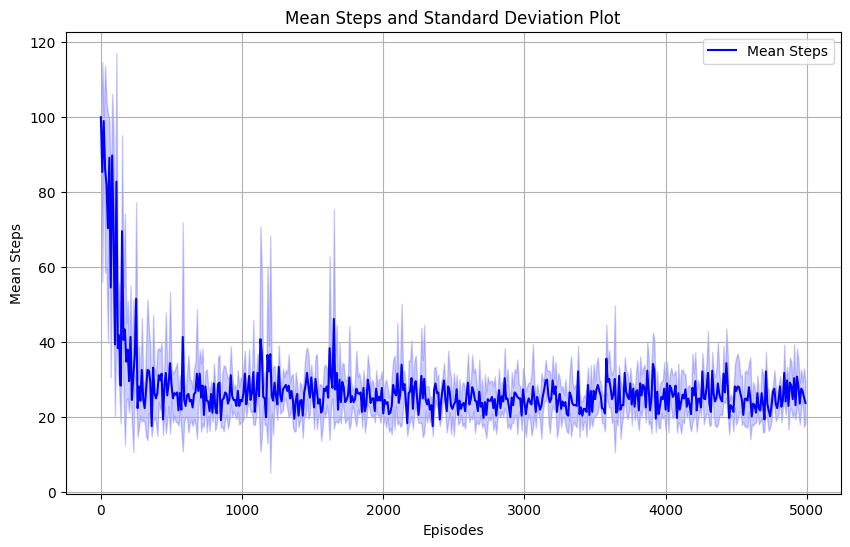

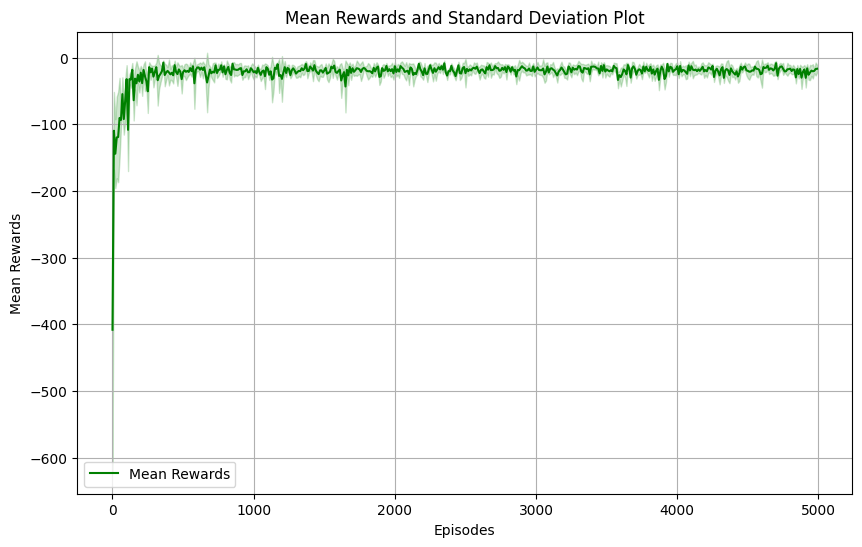

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


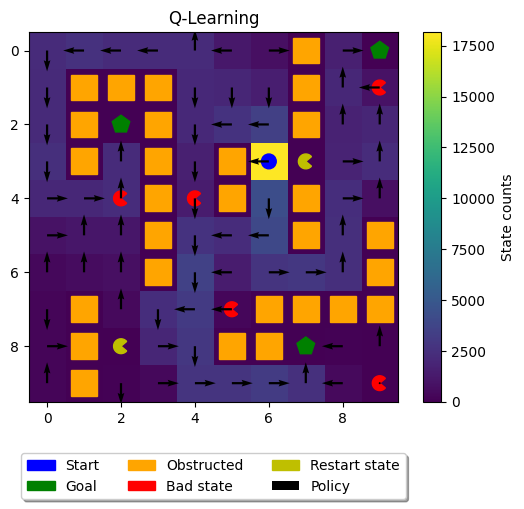

In [19]:

plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="Q-Learning")

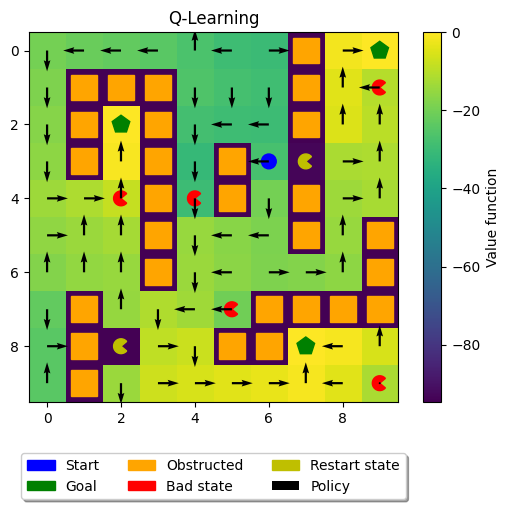

In [20]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="Q-Learning")

In [21]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)

env_1 = gw.create_gridworld()


In [22]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = qlearning(env_1, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials



[I 2024-02-27 18:41:37,712] A new study created in memory with name: no-name-462099d4-2a7b-4ed7-89b6-668b360599df
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:243: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:255: DeprecationWarning: Conversion of an array with ndi

Trial 0: Alpha = 0.35084084783729125, Epsilon = 0.3922872370155814,Gamma=0.815889589630267
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:42:29,832] Trial 0 finished with value: 231931.6 and parameters: {'alpha': 0.35084084783729125, 'epsilon': 0.3922872370155814, 'gamma': 0.815889589630267}. Best is trial 0 with value: 231931.6.


Trial 1: Alpha = 0.3606999466120908, Epsilon = 0.3441092831864669,Gamma=0.8521999399515995
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:43:17,166] Trial 1 finished with value: 207779.7 and parameters: {'alpha': 0.3606999466120908, 'epsilon': 0.3441092831864669, 'gamma': 0.8521999399515995}. Best is trial 1 with value: 207779.7.


Trial 2: Alpha = 0.47407386985369054, Epsilon = 0.3537690979987632,Gamma=0.845525638572338
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:44:22,263] Trial 2 finished with value: 243895.4 and parameters: {'alpha': 0.47407386985369054, 'epsilon': 0.3537690979987632, 'gamma': 0.845525638572338}. Best is trial 1 with value: 207779.7.


Trial 3: Alpha = 0.30537081638103647, Epsilon = 0.19400335423038875,Gamma=0.955759463351872
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:45:01,677] Trial 3 finished with value: 154352.7 and parameters: {'alpha': 0.30537081638103647, 'epsilon': 0.19400335423038875, 'gamma': 0.955759463351872}. Best is trial 3 with value: 154352.7.


Trial 4: Alpha = 0.3392494521903114, Epsilon = 0.11955385464396172,Gamma=0.8207096226957532
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:45:36,274] Trial 4 finished with value: 134414.2 and parameters: {'alpha': 0.3392494521903114, 'epsilon': 0.11955385464396172, 'gamma': 0.8207096226957532}. Best is trial 4 with value: 134414.2.


Trial 5: Alpha = 0.3860143031162274, Epsilon = 0.27176878682685873,Gamma=0.8040286533269171
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:46:21,101] Trial 5 finished with value: 185269.3 and parameters: {'alpha': 0.3860143031162274, 'epsilon': 0.27176878682685873, 'gamma': 0.8040286533269171}. Best is trial 4 with value: 134414.2.


Trial 6: Alpha = 0.12401228485185115, Epsilon = 0.3321041869777756,Gamma=0.8008945667522908
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:47:05,715] Trial 6 finished with value: 189231.7 and parameters: {'alpha': 0.12401228485185115, 'epsilon': 0.3321041869777756, 'gamma': 0.8008945667522908}. Best is trial 4 with value: 134414.2.


Trial 7: Alpha = 0.21280173519407322, Epsilon = 0.4934470278838519,Gamma=0.9725334825932771
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:48:05,104] Trial 7 finished with value: 265405.5 and parameters: {'alpha': 0.21280173519407322, 'epsilon': 0.4934470278838519, 'gamma': 0.9725334825932771}. Best is trial 4 with value: 134414.2.


Trial 8: Alpha = 0.4555055212121299, Epsilon = 0.46475715170316145,Gamma=0.9991825844858545
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:49:10,209] Trial 8 finished with value: 299047.6 and parameters: {'alpha': 0.4555055212121299, 'epsilon': 0.46475715170316145, 'gamma': 0.9991825844858545}. Best is trial 4 with value: 134414.2.


Trial 9: Alpha = 0.10292051286400455, Epsilon = 0.21242921976774534,Gamma=0.8301349240634699
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:49:49,926] Trial 9 finished with value: 161361.8 and parameters: {'alpha': 0.10292051286400455, 'epsilon': 0.21242921976774534, 'gamma': 0.8301349240634699}. Best is trial 4 with value: 134414.2.


Trial 10: Alpha = 0.2258081045624831, Epsilon = 0.10575219184209605,Gamma=0.894847236303577
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:50:23,276] Trial 10 finished with value: 126406.29999999999 and parameters: {'alpha': 0.2258081045624831, 'epsilon': 0.10575219184209605, 'gamma': 0.894847236303577}. Best is trial 10 with value: 126406.29999999999.


Trial 11: Alpha = 0.20537333240207525, Epsilon = 0.10403850520752511,Gamma=0.9008726078990825
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:50:56,649] Trial 11 finished with value: 126907.7 and parameters: {'alpha': 0.20537333240207525, 'epsilon': 0.10403850520752511, 'gamma': 0.9008726078990825}. Best is trial 10 with value: 126406.29999999999.


Trial 12: Alpha = 0.19501213176335577, Epsilon = 0.10085391830913358,Gamma=0.8999582010402921
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:51:29,804] Trial 12 finished with value: 126917.7 and parameters: {'alpha': 0.19501213176335577, 'epsilon': 0.10085391830913358, 'gamma': 0.8999582010402921}. Best is trial 10 with value: 126406.29999999999.


Trial 13: Alpha = 0.16381735795216298, Epsilon = 0.14960250770398031,Gamma=0.8988859343704393
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:52:04,987] Trial 13 finished with value: 137513.40000000002 and parameters: {'alpha': 0.16381735795216298, 'epsilon': 0.14960250770398031, 'gamma': 0.8988859343704393}. Best is trial 10 with value: 126406.29999999999.


Trial 14: Alpha = 0.25751211232037385, Epsilon = 0.14482523134612293,Gamma=0.9262556746367957
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:52:40,453] Trial 14 finished with value: 136117.40000000002 and parameters: {'alpha': 0.25751211232037385, 'epsilon': 0.14482523134612293, 'gamma': 0.9262556746367957}. Best is trial 10 with value: 126406.29999999999.


Trial 15: Alpha = 0.16647008583863782, Epsilon = 0.10272074675288656,Gamma=0.8798983044680639
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:53:15,997] Trial 15 finished with value: 128450.2 and parameters: {'alpha': 0.16647008583863782, 'epsilon': 0.10272074675288656, 'gamma': 0.8798983044680639}. Best is trial 10 with value: 126406.29999999999.


Trial 16: Alpha = 0.2524425899177232, Epsilon = 0.16345222001821408,Gamma=0.8705996941873273
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:53:51,996] Trial 16 finished with value: 139577.4 and parameters: {'alpha': 0.2524425899177232, 'epsilon': 0.16345222001821408, 'gamma': 0.8705996941873273}. Best is trial 10 with value: 126406.29999999999.


Trial 17: Alpha = 0.165721038157722, Epsilon = 0.12639465530202168,Gamma=0.9221726363856578
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:54:27,103] Trial 17 finished with value: 132719.4 and parameters: {'alpha': 0.165721038157722, 'epsilon': 0.12639465530202168, 'gamma': 0.9221726363856578}. Best is trial 10 with value: 126406.29999999999.


Trial 18: Alpha = 0.2654582385299775, Epsilon = 0.17544933008480595,Gamma=0.9228873169612964
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:55:03,761] Trial 18 finished with value: 143626.7 and parameters: {'alpha': 0.2654582385299775, 'epsilon': 0.17544933008480595, 'gamma': 0.9228873169612964}. Best is trial 10 with value: 126406.29999999999.


Trial 19: Alpha = 0.1319562718213528, Epsilon = 0.12253700831097547,Gamma=0.9449655868378646
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 18:55:38,909] Trial 19 finished with value: 136255.8 and parameters: {'alpha': 0.1319562718213528, 'epsilon': 0.12253700831097547, 'gamma': 0.9449655868378646}. Best is trial 10 with value: 126406.29999999999.


In [23]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)




Best Hyperparameters:
Best Alpha: 0.2258081045624831
Best Epsilon: 0.10575219184209605
Best gamma: 0.894847236303577


In [24]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_1, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:243: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:255: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array bef

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [25]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


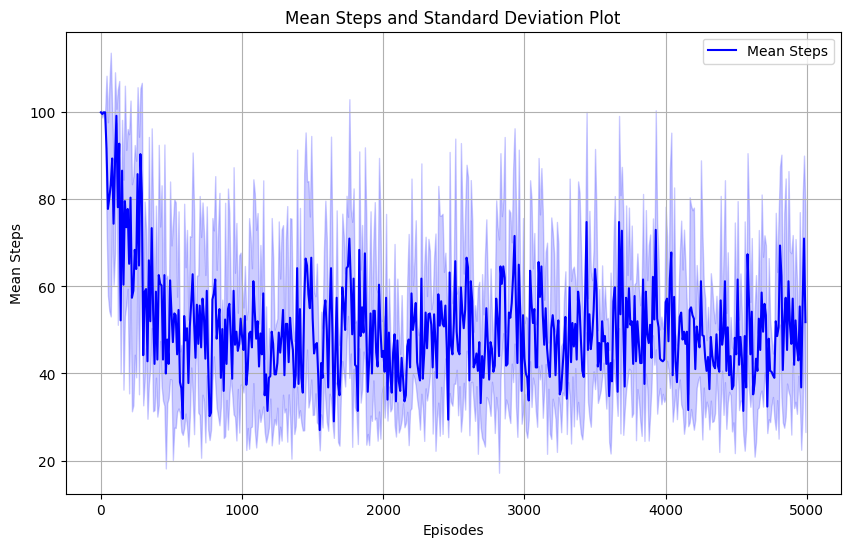

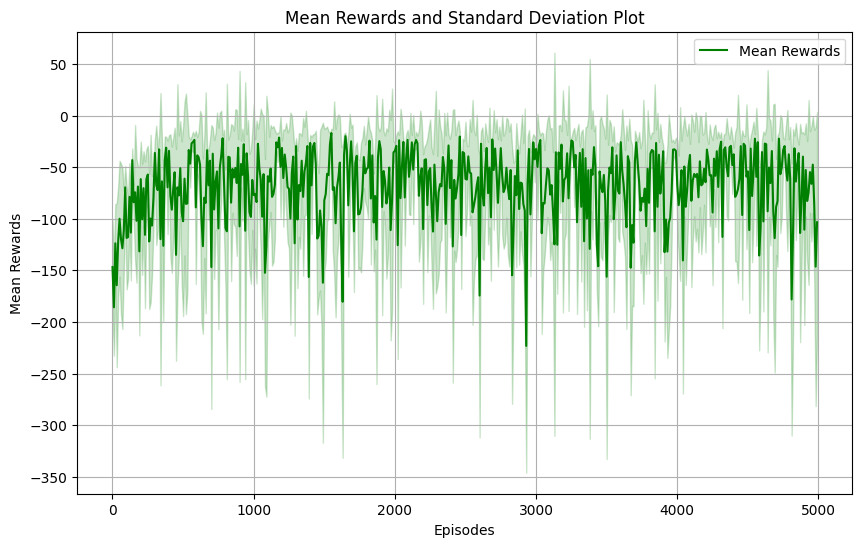

In [26]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


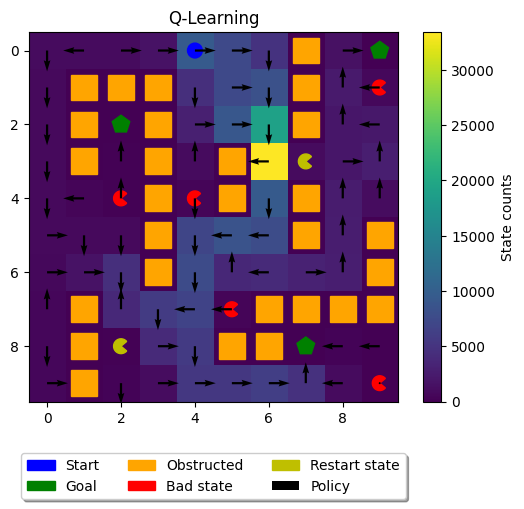

In [27]:


plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="Q-Learning")


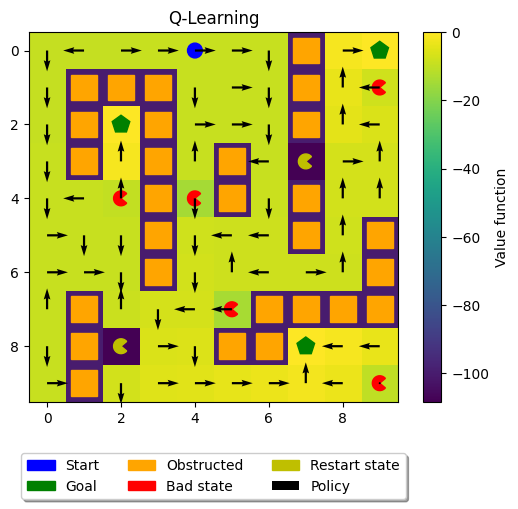

In [28]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="Q-Learning")


In [29]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                    bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = qlearning(env_1, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials


[I 2024-02-27 18:56:55,471] A new study created in memory with name: no-name-44337263-300a-4bd5-829a-423791d1f4e1
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:243: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:255: DeprecationWarning: Conversion of an array with ndi

Trial 0: Alpha = 0.10629635723706173, Temperature = 0.2189728974575042,Gamma=0.8143576157665927
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:00:44,684] Trial 0 finished with value: 482371.3 and parameters: {'alpha': 0.10629635723706173, 'temperature': 0.2189728974575042, 'gamma': 0.8143576157665927}. Best is trial 0 with value: 482371.3.


Trial 1: Alpha = 0.29897815819778495, Temperature = 0.5950451121054453,Gamma=0.8229018990643973
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:04:34,910] Trial 1 finished with value: 488871.4 and parameters: {'alpha': 0.29897815819778495, 'temperature': 0.5950451121054453, 'gamma': 0.8229018990643973}. Best is trial 0 with value: 482371.3.


Trial 2: Alpha = 0.46600712119442994, Temperature = 0.4625118936042809,Gamma=0.8014768058452488
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:08:52,601] Trial 2 finished with value: 492159.0 and parameters: {'alpha': 0.46600712119442994, 'temperature': 0.4625118936042809, 'gamma': 0.8014768058452488}. Best is trial 0 with value: 482371.3.


Trial 3: Alpha = 0.14841205864919865, Temperature = 0.5367301862569649,Gamma=0.8407248999535151
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:12:39,775] Trial 3 finished with value: 483475.4 and parameters: {'alpha': 0.14841205864919865, 'temperature': 0.5367301862569649, 'gamma': 0.8407248999535151}. Best is trial 0 with value: 482371.3.


Trial 4: Alpha = 0.31931850445249266, Temperature = 0.34243632667773755,Gamma=0.9445754613890337
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:14:44,570] Trial 4 finished with value: 240501.9 and parameters: {'alpha': 0.31931850445249266, 'temperature': 0.34243632667773755, 'gamma': 0.9445754613890337}. Best is trial 4 with value: 240501.9.


Trial 5: Alpha = 0.2999656006511677, Temperature = 0.45744624761417124,Gamma=0.8145615529298668
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:18:47,163] Trial 5 finished with value: 489035.0 and parameters: {'alpha': 0.2999656006511677, 'temperature': 0.45744624761417124, 'gamma': 0.8145615529298668}. Best is trial 4 with value: 240501.9.


Trial 6: Alpha = 0.24995983338664332, Temperature = 0.2874666542809839,Gamma=0.839694970613694
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:23:02,637] Trial 6 finished with value: 477782.1 and parameters: {'alpha': 0.24995983338664332, 'temperature': 0.2874666542809839, 'gamma': 0.839694970613694}. Best is trial 4 with value: 240501.9.


Trial 7: Alpha = 0.2515000215556877, Temperature = 0.4691956897617401,Gamma=0.9901487697759611
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:24:05,980] Trial 7 finished with value: 115553.5 and parameters: {'alpha': 0.2515000215556877, 'temperature': 0.4691956897617401, 'gamma': 0.9901487697759611}. Best is trial 7 with value: 115553.5.


Trial 8: Alpha = 0.12126287816207292, Temperature = 0.16776526071549702,Gamma=0.9571748628289722
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:25:24,993] Trial 8 finished with value: 134732.6 and parameters: {'alpha': 0.12126287816207292, 'temperature': 0.16776526071549702, 'gamma': 0.9571748628289722}. Best is trial 7 with value: 115553.5.


Trial 9: Alpha = 0.44707429401902427, Temperature = 0.1352905915018075,Gamma=0.8140350447191844
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:29:23,136] Trial 9 finished with value: 474837.7 and parameters: {'alpha': 0.44707429401902427, 'temperature': 0.1352905915018075, 'gamma': 0.8140350447191844}. Best is trial 7 with value: 115553.5.


Trial 10: Alpha = 0.17946321649613498, Temperature = 0.9809277482261404,Gamma=0.9938904977849129
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:31:03,139] Trial 10 finished with value: 202863.59999999998 and parameters: {'alpha': 0.17946321649613498, 'temperature': 0.9809277482261404, 'gamma': 0.9938904977849129}. Best is trial 7 with value: 115553.5.


Trial 11: Alpha = 0.11082024965144789, Temperature = 0.10014932286594433,Gamma=0.9911611112493383
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:32:06,164] Trial 11 finished with value: 122993.2 and parameters: {'alpha': 0.11082024965144789, 'temperature': 0.10014932286594433, 'gamma': 0.9911611112493383}. Best is trial 7 with value: 115553.5.


Trial 12: Alpha = 0.18133424874818999, Temperature = 0.10002398214288105,Gamma=0.9999420902973779
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:33:05,119] Trial 12 finished with value: 109994.1 and parameters: {'alpha': 0.18133424874818999, 'temperature': 0.10002398214288105, 'gamma': 0.9999420902973779}. Best is trial 12 with value: 109994.1.


Trial 13: Alpha = 0.19487524809076345, Temperature = 0.8009269314173645,Gamma=0.9079166598531563
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:36:45,134] Trial 13 finished with value: 452947.5 and parameters: {'alpha': 0.19487524809076345, 'temperature': 0.8009269314173645, 'gamma': 0.9079166598531563}. Best is trial 12 with value: 109994.1.


Trial 14: Alpha = 0.21788533966741766, Temperature = 0.24272071722058594,Gamma=0.9574251560661702
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:37:56,822] Trial 14 finished with value: 132507.8 and parameters: {'alpha': 0.21788533966741766, 'temperature': 0.24272071722058594, 'gamma': 0.9574251560661702}. Best is trial 12 with value: 109994.1.


Trial 15: Alpha = 0.1557219383953494, Temperature = 0.36636942496900465,Gamma=0.8976095056739312
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:41:50,768] Trial 15 finished with value: 441768.0 and parameters: {'alpha': 0.1557219383953494, 'temperature': 0.36636942496900465, 'gamma': 0.8976095056739312}. Best is trial 12 with value: 109994.1.


Trial 16: Alpha = 0.2562837054146892, Temperature = 0.10048069249391656,Gamma=0.9245460226016559
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:44:01,898] Trial 16 finished with value: 213989.59999999998 and parameters: {'alpha': 0.2562837054146892, 'temperature': 0.10048069249391656, 'gamma': 0.9245460226016559}. Best is trial 12 with value: 109994.1.


Trial 17: Alpha = 0.36310571192279134, Temperature = 0.1722275485261549,Gamma=0.8637113422367009
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:47:46,732] Trial 17 finished with value: 452840.4 and parameters: {'alpha': 0.36310571192279134, 'temperature': 0.1722275485261549, 'gamma': 0.8637113422367009}. Best is trial 12 with value: 109994.1.


Trial 18: Alpha = 0.13934526725638074, Temperature = 0.6908888809819671,Gamma=0.9746855870600443
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:49:39,435] Trial 18 finished with value: 223300.2 and parameters: {'alpha': 0.13934526725638074, 'temperature': 0.6908888809819671, 'gamma': 0.9746855870600443}. Best is trial 12 with value: 109994.1.


Trial 19: Alpha = 0.190866857535599, Temperature = 0.42270875429523863,Gamma=0.9303635419211993
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 19:52:36,180] Trial 19 finished with value: 349501.5 and parameters: {'alpha': 0.190866857535599, 'temperature': 0.42270875429523863, 'gamma': 0.9303635419211993}. Best is trial 12 with value: 109994.1.


In [30]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.18133424874818999
Best temp: 0.10002398214288105
Best gamma: 0.9999420902973779


In [31]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_1, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.


/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:229: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:243: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_6301/1446210169.py:255: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array bef

Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [32]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


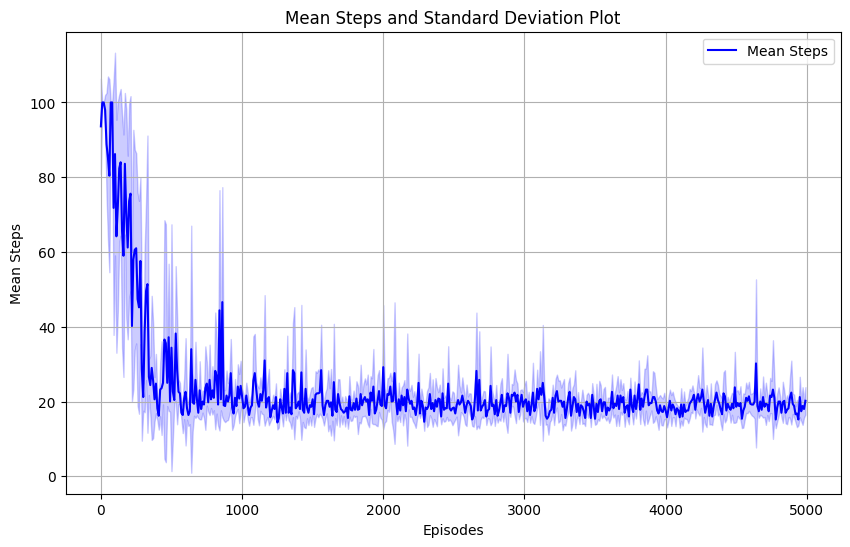

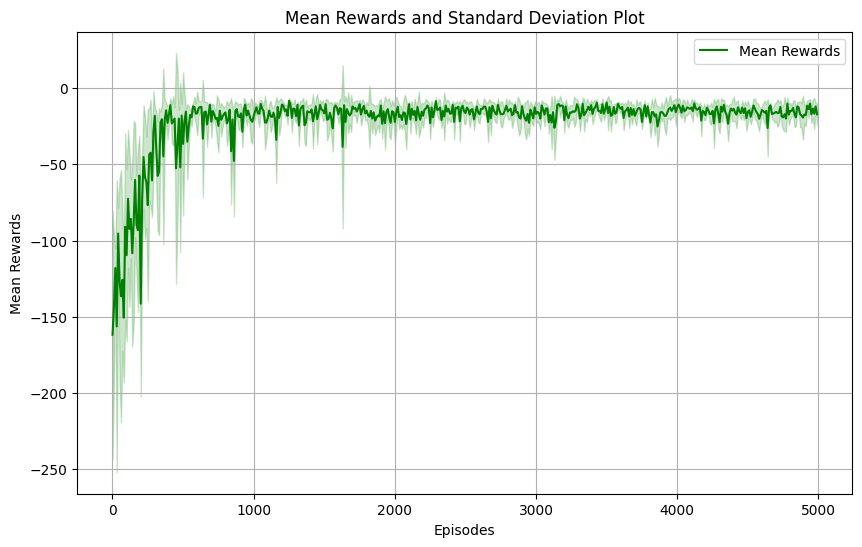

In [33]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


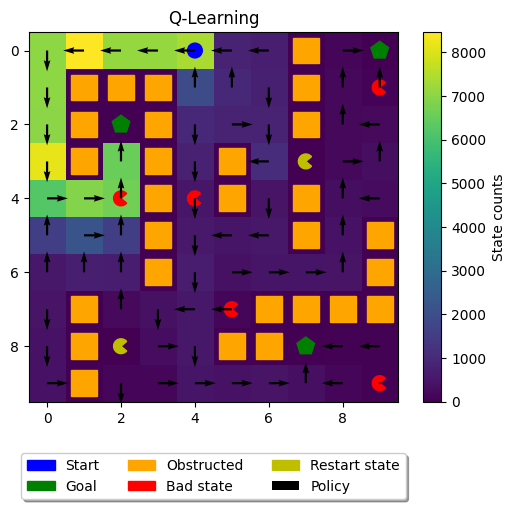

In [34]:



plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="Q-Learning")


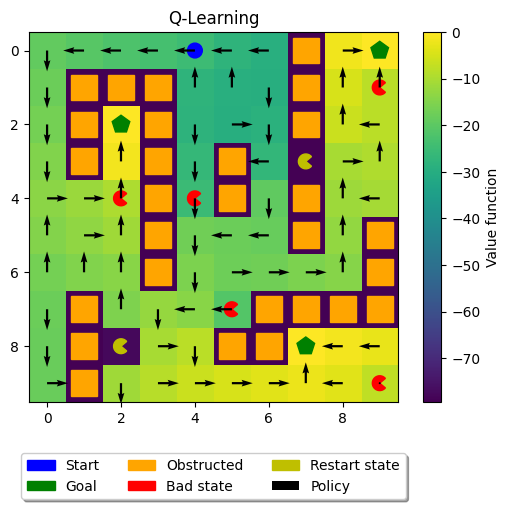

In [35]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="Q-Learning")